# 加载包

In [1]:
import sys
import os
from pathlib import Path

# 项目根目录
proj_root = Path("/home/yangk/intership_2025_COSYS")
# src路径
src_path = proj_root / "src"
# 加入 sys.path
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from nms import get_nms_edge_batch, get_nms_edge
from dataset import BIPEDv2

# DexiNed 目录
dexined_path = proj_root / 'resource/DexiNed'
# 加入 sys.path
if str(dexined_path) not in sys.path:
    sys.path.append(str(dexined_path))
from model import DexiNed

# 加载BIPEDv2数据

In [2]:
from pathlib import Path

data_prefix = dexined_path / "BIPEDv2/BIPED/edges"

test_dataset = BIPEDv2(
    data_prefix / "imgs" / "test" / "rgbr",
    data_prefix / "edge_maps" / "test" / "rgbr"
)

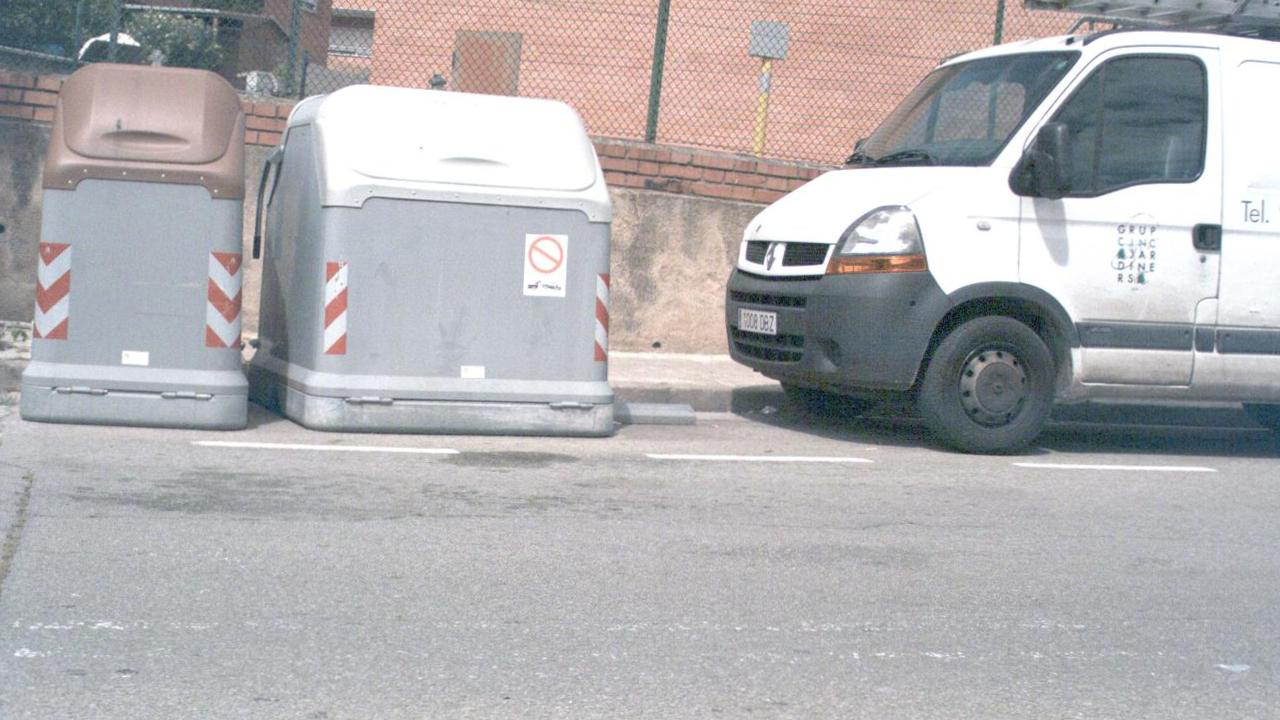

In [3]:
from PIL import Image

item = test_dataset[0]
Image.open(item['image_path'])

# 加载模型和日志

In [4]:
from pathlib import Path
import torch
import json

cpt_path = proj_root / "src" / "checkpoints" / "cpt_visibility_04"

model = DexiNed()
model.load_state_dict(torch.load(cpt_path.with_suffix(".pth"), weights_only=True))
with open(cpt_path.with_suffix(".json"), 'r') as f:
    logging = json.load(f)

# 推理 | inference

In [5]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

# load one image
x = test_dataset[0]['image_tensor']

model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    yhat = get_nms_edge(yhat)
    model.to('cpu')

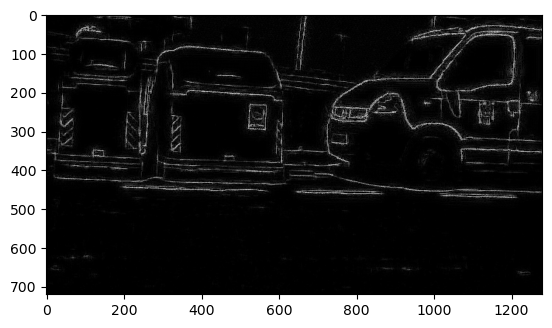

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def normalisation(img, percentile=95):
    res = img / np.percentile(img, percentile)
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res)
    return res

plt.imshow(normalisation(yhat, 99), cmap="gray")
plt.show()

# Lucas 的图

In [ ]:
suffixes =['.jpg', '.png']

lucas_image_folder = proj_root / "resource/Lucas.old/images"

lucas_real = [f for f in lucas_image_folder.joinpath("real").glob("*") if f.suffix.lower() in suffixes]
lucas_sine = [f for f in lucas_image_folder.joinpath("sines-targets").glob("*") if f.suffix.lower() in suffixes]

In [ ]:
from dataset import TRANSFORM, ANALYSER
# DexiNed 目录
lucas_path = proj_root / 'resource/Lucas.old'
# 加入 sys.path
if str(lucas_path) not in sys.path:
    sys.path.append(str(lucas_path))

from ImageProcessing.ImageGenerator import Image as ImageGenerator
from ImageProcessing.ImageAnalyzer import ImageAnalyzer
from ImageProcessing.ConvolutionFilter import Filter
from Parameters import WEIGHT_LIST, SIGMA_LIST
from torchvision import transforms
import cv2
import torch.nn.functional as F

def resize_t(image_2d, size):
    return F.interpolate(image_2d.unsqueeze(0).unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze()

def show_result(image_file, model=model, device=device):
    # inference by model
    # read image
    I = Image.open(image_file).convert("RGB")
    W, H = I.size
    # to tensor and normalize
    x = TRANSFORM(I)
    # inference
    model.eval()
    with torch.no_grad():
        model.to(device)
        yhat = model(x.unsqueeze(0).to(device))[-1]
        yhat = yhat.squeeze().to('cpu')
        yhat_nms = get_nms_edge(yhat)
        model.to('cpu')
    # the result of lucas
    img = ImageGenerator()
    analyser = ImageAnalyzer(
        Filter(distance_from_screen=50, sigma_list=SIGMA_LIST, weight_list=WEIGHT_LIST) # sDoG filter
    )
    img.load_image(str(image_file))
    # analyse and calculate
    img.convert_into_linear_space()
    analyser.generate_visibility_map(img)
    # display
    fig, axes = plt.subplots(2, 2, figsize=(16, 9))  
    # original image
    axes[0,0].imshow(Image.open(image_file))
    axes[0,0].set_title("Original image")
    # axes[0,1].axis('off')  # 不显示坐标轴
    # Lucas
    axes[0,1].imshow(normalisation(analyser.visibility_map, 98), cmap="gray")
    axes[0,1].set_title("Lucas")
    # axes[0,1].axis('off')  # 不显示坐标轴
    # Dexined
    axes[1,0].imshow(normalisation(resize_t(yhat,(H, W)) , 98), cmap="gray")
    axes[1,0].set_title("Prediction without NMS")
    # axes[1,0].axis('off')  # 不显示坐标轴
    axes[1,1].imshow(normalisation(resize_t(yhat_nms, (H, W)), 98), cmap="gray")
    axes[1,1].set_title("Prediction with NMS")
    # axes[1,1].axis('off')  # 不显示坐标轴

    plt.tight_layout()  # 自动调整子图间距
    plt.show()


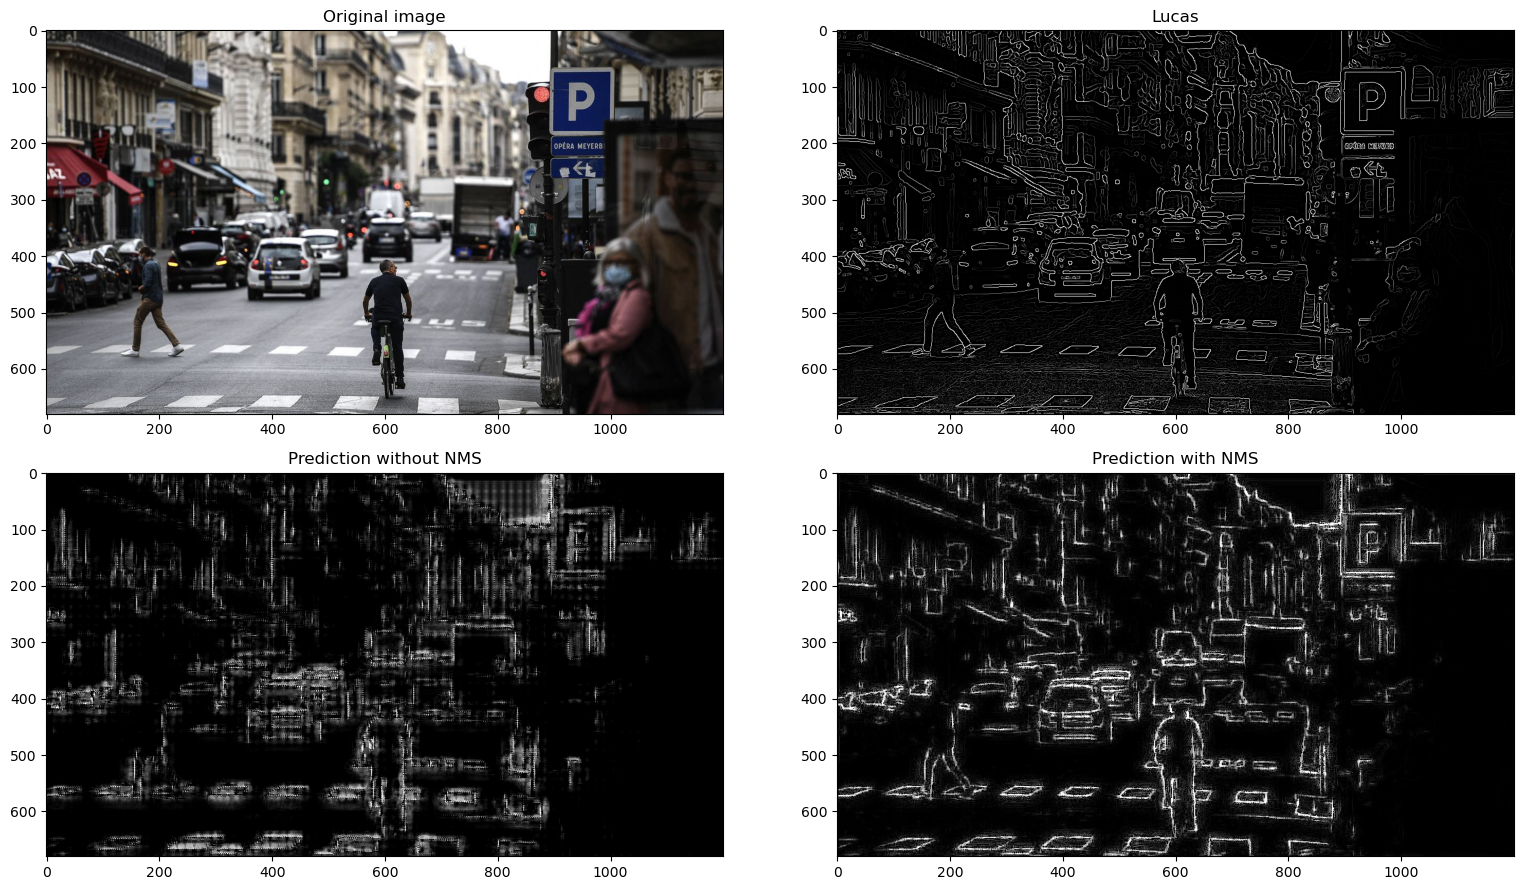

In [24]:
show_result(lucas_real[2])

# All together | 大集合

In [36]:
model1 = DexiNed()
cpt_path = proj_root / "demo/demo_Dexined/checkpoints" / "cpt_visibility_04"
model1.load_state_dict(torch.load(cpt_path.with_suffix(".pth"), weights_only=True))

model2 = DexiNed()
cpt_path = proj_root / "src" / "checkpoints" / "cpt_visibility_04"
model2.load_state_dict(torch.load(cpt_path.with_suffix(".pth"), weights_only=True))

def show_all(image_file):
    # read image
    I = Image.open(image_file).convert("RGB")
    W, H = I.size
    # without NMS
    x = TRANSFORM(I)
    # inference model 1
    model1.eval()
    with torch.no_grad():
        model1.to(device)
        yhat = model1(x.unsqueeze(0).to(device))[-1]
        yhat = yhat.squeeze().to('cpu')
        model1.to('cpu')
    visib1 = resize_t(yhat, (H, W))
    visib1_nms = resize_t(get_nms_edge(yhat), (H, W))
    # inference model 2
    model2.eval()
    with torch.no_grad():
        model2.to(device)
        yhat = model2(x.unsqueeze(0).to(device))[-1]
        yhat = yhat.squeeze().to('cpu')
        model2.to('cpu')
    visib2 = resize_t(yhat, (H, W))
    visib2_nms = resize_t(get_nms_edge(yhat), (H, W))
    # the result of lucas
    img = ImageGenerator()
    analyser = ImageAnalyzer(
        Filter(distance_from_screen=50, sigma_list=SIGMA_LIST, weight_list=WEIGHT_LIST) # sDoG filter
    )
    img.load_image(str(image_file))
    img.convert_into_linear_space()
    analyser.generate_visibility_map(img)
    visib_lucas = analyser.visibility_map

    denom = normalisation(visib_lucas, 98).max()

    # display
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))  
    # original image
    axes[0,0].imshow(Image.open(image_file))
    axes[0,0].set_title("Original image")
    # Lucas
    axes[0,1].imshow(normalisation(visib_lucas, 98), cmap="gray")
    axes[0,1].set_title("Lucas")
    # Dexined 1
    axes[1,0].imshow(normalisation(visib1, 98), cmap="gray")
    axes[1,0].set_title("Prediction without NMS (train without NMS)")
    axes[1,1].imshow(normalisation(visib1_nms, 98), cmap="gray")
    axes[1,1].set_title("Prediction with NMS (train without NMS)")
    # Dexined 2
    axes[2,0].imshow(normalisation(visib2, 98), cmap="gray")
    axes[2,0].set_title("Prediction without NMS (train with NMS)")
    axes[2,1].imshow(normalisation(visib2_nms, 98), cmap="gray")
    axes[2,1].set_title("Prediction with NMS (train with NMS)")

    plt.tight_layout()  # 自动调整子图间距
    plt.show()

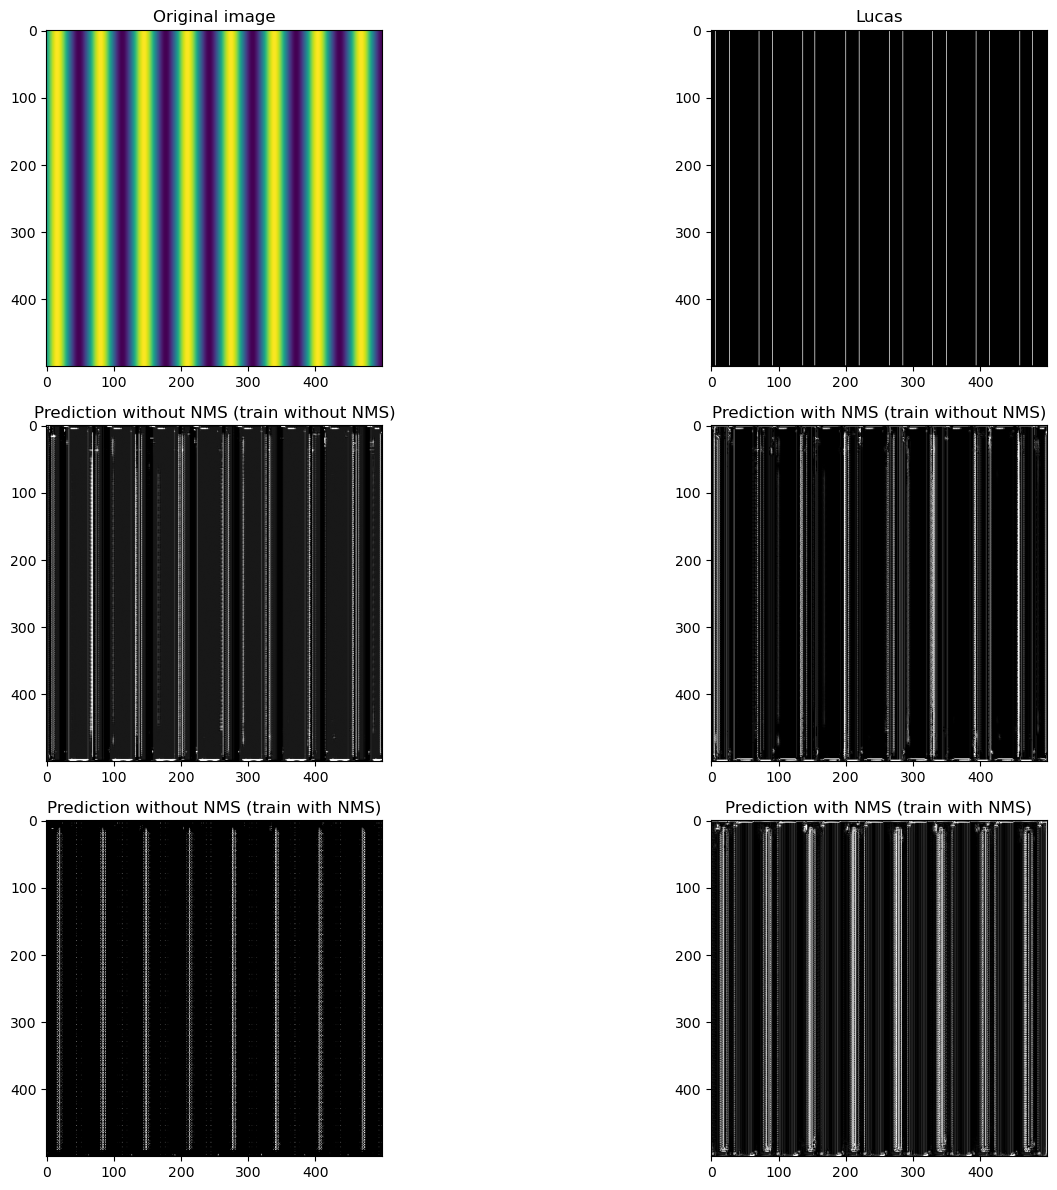

In [37]:
show_all(lucas_sine[2])